# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

In [2]:
CONFIG = {
    # Data
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    'subset_ratio': 0.007,              # Will be overridden manually to 200 images
    'force_subset_images': 200,         # <== NEW: force subset by image count

    # Vocabulary
    'vocab_min_count': 1,               # Include all words to memorize exact text
    'max_length': 30,

    # Model Architecture
    'embedding_dim': 512,
    'units': 512,
    'decoder_dropout': 0.0,

    # Training
    'seed': 42,
    'epochs': 150,                      # High value to let it memorize
    'early_stop': False,                # Disable early stopping
    'patience': 10,
    'learning_rate': 3e-4,
    'grad_clip_value': 5.0,
    'scheduled_sampling_max_prob': 0.0, # Turn off for memorization

    # Performance
    'batch_size': 32,                   # Smaller batch for more precise updates
    'buffer_size': 10000,
    'mixed_precision': False,

    # Checkpoints
    'checkpoint_dir': './checkpoints/overfit_200',
    'save_checkpoints': False,
    'delete_old_checkpoints': True,

    # Attention regularizer
    'attention_reg_lambda': 1.0
}

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

Using single GPU: /physical_device:GPU:0, batch size=32


In [4]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. Build (image, caption) pairs ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        # --- 5. Force fixed number of images if requested -----------------------
        if 'force_subset_images' in self.config and self.config['force_subset_images']:
            requested = self.config['force_subset_images']
            print(f"Forcing subset of exactly {requested} images...")
            all_imgs = list({img for img, _ in pairs})
            if requested > len(all_imgs):
                raise ValueError(f"Requested {requested} images, but only {len(all_imgs)} available.")
            selected_imgs = set(random.sample(all_imgs, requested))
            pairs = [(img, cap) for img, cap in pairs if img in selected_imgs]
            print(f"Subset contains {len(pairs)} (image, caption) pairs from {requested} images.")
        
        # --- 6. Subset by ratio if no forced image count ------------------------
        elif subset_ratio < 1.0:
            orig_len = len(pairs)
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"Subset by ratio: {len(pairs)} pairs from {orig_len}")

        # --- 7. Split into train/val/test ---------------------------------------
        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8 * n)],
            pairs[int(0.8 * n):int(0.9 * n)],
            pairs[int(0.9 * n):]
        )
        print(f"split → train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered

        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """Generator for *training* / *val* datasets."""
        for img, cap in data:
            img_path = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len
    
    def build_dataset(self, data, shuffle=True, cache=True, training: bool=True):
        """Create a tf.data.Dataset optimized for single GPU."""
        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),
            tf.TensorSpec((self.config['max_length'],), tf.int32),
            tf.TensorSpec((), tf.int32)
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature
        )

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [5]:
class Encoder(Model):
    """
    Inception-V3 feature extractor with an optional
    `unfreeze_top_layers()` helper for later fine-tuning.
    """
    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False, weights='imagenet',
            input_shape=(299, 299, 3))
        base.trainable = False                                      # phase-1: frozen
        self.cnn = Model(inputs=base.input, outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))                  # L=64 for 8×8 grid

    def unfreeze_top_layers(self, n: int = 2):
        """
        Fine-tune: unfreeze the last *n* Inception blocks (default: mixed9 & mixed10).
        Call **after** initial caption training for best accuracy.
        """
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                                             # (B,299,299,3)
        x = self.cnn(x)                                            # (B,8,8,2048)
        return self.reshape(x)                                     # (B,64,2048)

In [6]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [7]:
class Decoder(Model):
    """
    Attention decoder with configurable dropout via config.
    """
    def __init__(self, embedding_dim: int, units: int, vocab_size: int, dropout: float = 0.5):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation="sigmoid")
        self.lstm      = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout   = layers.Dropout(dropout)

        self.deep_proj = layers.Dense(units * 2)
        self.fc        = layers.Dense(vocab_size)

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)
        context = self.f_beta(hidden) * context

        x = self.embedding(x)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell, lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)

        proj = self.deep_proj(tf.concat([lstm_out, context], -1))
        proj = tf.reshape(proj, (-1, self.units, 2))
        maxout = tf.reduce_max(proj, axis=-1)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

In [8]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config          = config
        self.processor       = processor
        self.encoder         = None
        self.decoder         = None
        self.optimizer       = None
        self.loss_fn         = None
        self.ckpt_manager    = None

        self.best_bleu       = 0.0
        self.train_loss_log  = []
        self.train_bleu_log  = []
        self.val_bleu_log    = []
        self.bleu_subset_idx = None  

        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        print("Building model for single GPU...")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'],
            units=self.config['units'],
            vocab_size=self.processor.vocab_size,
            dropout=self.config.get('decoder_dropout', 0.5)
        )

        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=10000
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        if not self.config.get('save_checkpoints', True):
            print("Checkpoint saving disabled.")
            return

        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)

        max_keep = 1 if self.config.get('delete_old_checkpoints', True) else 5
        ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                decoder=self.decoder,
                                optimizer=self.optimizer)
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=max_keep)

        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Restored from checkpoint: {self.ckpt_manager.latest_checkpoint}")

    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # --- Encoder Summary ---
        print("\nEncoder Summary:")
        self.encoder(dummy_image)
        self.encoder.summary()

        # --- Bahdanau Attention Summary ---
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # --- Decoder Summary ---
        print("\nDecoder Summary:")
        self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        self.decoder.summary()

    @tf.function
    def train_step(self,
                   img_tensor: tf.Tensor,
                   target:     tf.Tensor,
                   cap_len:    tf.Tensor) -> tf.Tensor:
        """
        Single step with:
        • β-gated attention + doubly-stochastic regulariser   (already present)
        • **Scheduled sampling** controlled by `self.ss_prob`.
        """
        batch_size = tf.shape(img_tensor)[0]
        hidden     = tf.zeros((batch_size, self.config['units']))
        cell       = tf.zeros_like(hidden)

        start_tok  = self.processor.tokenizer.word_index['<start>']
        dec_input  = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

        attention_accum = None
        total_ce_loss   = 0.0

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)  # (B, L, 2048)

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(
                    dec_input, features, hidden, cell)

                # accumulate α for doubly-stochastic term
                attention_accum = (alpha if attention_accum is None
                                   else attention_accum + alpha)

                # CE loss
                ce_t  = self.loss_fn(target[:, t], tf.squeeze(logits, 1))
                mask  = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                # ---- scheduled sampling decision ----
                # predicted tokens
                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)  # (B,1) → (B,)
                pred_ids = tf.squeeze(pred_ids, -1)

                # Bernoulli mask: 1 → use prediction
                ss_mask = tf.random.uniform((batch_size,)) < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])

                dec_input = tf.expand_dims(next_ids, 1)

            # normalise CE by real tokens
            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens

            # doubly-stochastic regulariser
            lambda_reg = self.config.get('attention_reg_lambda', 1.0)
            reg_loss   = tf.reduce_mean(tf.square(1.0 - attention_accum))
            loss       = ce_loss + lambda_reg * reg_loss

            if self.config['mixed_precision']:
                loss = tf.cast(loss, tf.float32)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss, variables)

        if self.config['mixed_precision']:
            grads = [tf.cast(g, tf.float32) if g is not None else None
                     for g in grads]

        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        return loss

    def beam_search_decode(self,
                           image_path: str,
                           beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        """Beam-search with deterministic crop."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )
        base_features = self.encoder(img_tensor)       # (1,L,2048)

        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        beams = [{'seq':[start_id],
                  'score':0.0,
                  'hidden':tf.zeros((1,self.config['units'])),
                  'cell':tf.zeros((1,self.config['units'])),
                  'alphas':[]}]

        completed = []
        for _ in range(self.config['max_length']):
            candidates = []
            for b in beams:
                last_id = b['seq'][-1]
                if last_id == end_id:
                    completed.append(b); continue
                dec_in = tf.expand_dims([last_id], 0)
                logits, h, c, alpha = self.decoder(dec_in, base_features,
                                                   b['hidden'], b['cell'])
                log_probs = tf.nn.log_softmax(logits[0,0])
                top_ids = tf.math.top_k(log_probs, k=beam_size).indices.numpy()
                for tok in top_ids:
                    tok = int(tok)
                    candidates.append({
                        'seq':   b['seq']+[tok],
                        'score': b['score']+float(log_probs[tok]),
                        'hidden':h,
                        'cell':  c,
                        'alphas':b['alphas']+[alpha[0].numpy()]})
            if not candidates: break
            def lp(b): return b['score']/(len(b['seq'])**length_penalty)
            candidates.sort(key=lp, reverse=True)
            beams = candidates[:beam_size]
            if len(completed) >= beam_size: break

        best = max(completed+beams,
                   key=lambda b: b['score']/(len(b['seq'])**length_penalty))
        words = [self.processor.tokenizer.index_word.get(i,'')
                 for i in best['seq']
                 if self.processor.tokenizer.index_word.get(i,'') not in
                 ('<start>','<end>','<unk>')]
        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        """Generate caption via greedy decoding (deterministic crop)."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )

        features = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell   = tf.zeros_like(hidden)
        dec_input = tf.expand_dims(
            [self.processor.tokenizer.word_index['<start>']], 0
        )

        result, alphas = [], []
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(
                dec_input, features, hidden, cell
            )
            pred_id = tf.argmax(logits[0, 0]).numpy()
            word = self.processor.tokenizer.index_word.get(pred_id, '')
            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                result.append(word)
            alphas.append(alpha[0].numpy())
            dec_input = tf.expand_dims([pred_id], 0)

        return (result, alphas) if return_attention else result

    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores
    
    def train(self, train_ds, val_data, epochs=None, subset_size: int = 200):
        if epochs is None:
            epochs = self.config['epochs']

        if self.bleu_subset_idx is None:
            total_train = len(self.processor.train_data)
            subset_size = min(subset_size, total_train)
            self.bleu_subset_idx = random.sample(range(total_train), subset_size)

        def _subset(data, idx):
            return [data[i] for i in idx]

        patience = self.config.get('patience', 8)
        wait = 0
        apply_early_stop = self.config.get('early_stop', True)
        self.ss_max_prob = self.config.get('scheduled_sampling_max_prob', 0.0)

        for epoch in range(epochs):
            self.ss_prob = self.ss_max_prob * epoch / max(1, epochs - 1)
            print(f"\nEpoch {epoch+1}/{epochs}  (ε = {self.ss_prob:.3f})")

            start, total_loss, step = time.time(), 0.0, 0
            progbar = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            for batch, (img_tensor, target, cap_len) in enumerate(train_ds):
                if batch == 0 and progbar.target is None:
                    progbar.target = len(self.processor.train_data) // self.config['batch_size'] + 1

                batch_loss = self.train_step(img_tensor, target, cap_len)
                total_loss += batch_loss
                progbar.update(batch + 1, values=[('loss', batch_loss)])
                step += 1

            avg_loss = total_loss / step
            self.train_loss_log.append(float(avg_loss))

            train_subset = _subset(self.processor.train_data, self.bleu_subset_idx)
            train_bleu = self.evaluate_bleu(train_subset)['bleu-4']
            self.train_bleu_log.append(train_bleu)

            val_bleu = self.evaluate_bleu(val_data)['bleu-4']
            self.val_bleu_log.append(val_bleu)

            if self.ckpt_manager and self.config.get('save_checkpoints', True):
                self.ckpt_manager.save()

            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if apply_early_stop and wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}  "
                f"train-BLEU={train_bleu:.4f}  val-BLEU={val_bleu:.4f}  "
                f"time={time.time()-start:.1f}s", flush=True)

        return self.train_loss_log, self.val_bleu_log
    
    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Improved visualization of attention with better contrast and 299x299 alignment."""
        img = np.array(Image.open(image_path).resize((299, 299)))
        fig = plt.figure(figsize=(15, 8))

        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption) / 3)), t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape((attention_shape, attention_shape))

            # Normalize and boost contrast
            alpha -= alpha.min()
            if alpha.max() > 0:
                alpha /= alpha.max()

            # Resize attention map to 299×299
            alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)
            alpha_resized = np.array(alpha_resized) / 255.0  # back to [0,1] float

            ax.imshow(alpha_resized, cmap='jet', alpha=0.5, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(self,
             image_path: str,
             filename: str = "caption_audio.mp3",
             beam_size: int = 5,
             length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference) in the following order:
          1. Original image
          2. Ground-truth captions
          3. Generated caption
          4. Audio playback
          5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------- 1. original image ----------
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # ---------- 2. ground-truth captions ----------
        img_name = os.path.basename(image_path)
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(f"- {cap}")
        else:
            print("No ground-truth captions found.")

        # ---------- 3. caption generation ----------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------- 4. audio ----------
        self.speak_caption(caption, filename=filename)

        # ---------- 5. attention plot ----------
        self.plot_attention(image_path, words, attention)


    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")

In [9]:
processor = DataProcessor(CONFIG)

In [10]:
_ = processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


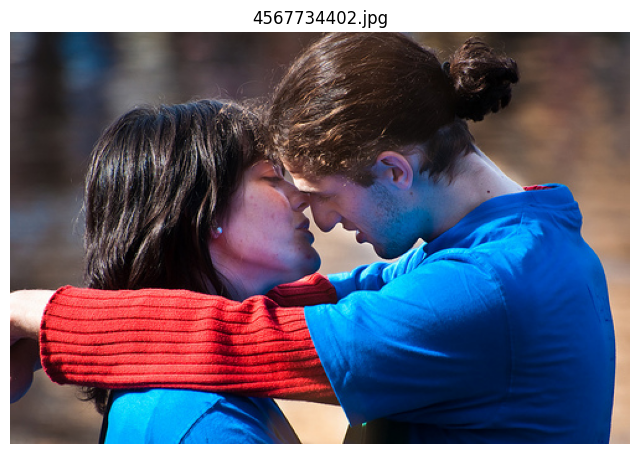

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



In [11]:
processor.display_samples(1)

In [12]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

max_length set to 25
vocab size = 20062
Forcing subset of exactly 200 images...
Subset contains 1000 (image, caption) pairs from 200 images.
split → train 800 | val 100 | test 100


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> two friends enjoy time spent together . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start>

In [13]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [14]:
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model for single GPU...
Checkpoint saving disabled.


In [15]:
model.summary()

Building model summaries...

Encoder Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        21802784  
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

Bahdanau Attention Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 64, 2048)]   0           []                               
                                                      

In [16]:
model.prime_dataset(train_ds, steps=20)

In [17]:
len(processor.val_data)

100

In [18]:
reduced_val = random.sample(processor.val_data, min(len(processor.val_data), 10))

In [19]:
model.prime_dataset(ds=train_ds, steps=50)

In [20]:
# model.train(train_ds, processor.val_data)
model.train(train_ds=train_ds, val_data=reduced_val)


Epoch 1/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 5.9741

100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


BLEU-1: 0.2743
BLEU-2: 0.0107
BLEU-3: 0.0030
BLEU-4: 0.0014


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]

BLEU-1: 0.2604
BLEU-2: 0.0357
BLEU-3: 0.0153
BLEU-4: 0.0087
Epoch 1: loss=7.0699  train-BLEU=0.0014  val-BLEU=0.0087  time=48.5s

Epoch 2/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 5.3867

25/26 [===========================>..] - ETA: 0s - loss: 5.1961

100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


BLEU-1: 0.2824
BLEU-2: 0.0111
BLEU-3: 0.0033
BLEU-4: 0.0016


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]

BLEU-1: 0.2655
BLEU-2: 0.0358
BLEU-3: 0.0158
BLEU-4: 0.0095
Epoch 2: loss=5.3438  train-BLEU=0.0016  val-BLEU=0.0095  time=34.9s



Epoch 3/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 5.2227

100%|██████████| 200/200 [00:37<00:00,  5.27it/s]


BLEU-1: 0.3780
BLEU-2: 0.0127
BLEU-3: 0.0034
BLEU-4: 0.0015


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]

BLEU-1: 0.3518
BLEU-2: 0.0413
BLEU-3: 0.0167
BLEU-4: 0.0093
Epoch 3: loss=5.1368  train-BLEU=0.0015  val-BLEU=0.0093  time=43.6s

Epoch 4/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 5.0002

25/26 [===========================>..] - ETA: 0s - loss: 4.9680

100%|██████████| 200/200 [00:39<00:00,  5.02it/s]


BLEU-1: 0.3420
BLEU-2: 0.0115
BLEU-3: 0.0030
BLEU-4: 0.0014


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]

BLEU-1: 0.3214
BLEU-2: 0.0380
BLEU-3: 0.0153
BLEU-4: 0.0084
Epoch 4: loss=5.0038  train-BLEU=0.0014  val-BLEU=0.0084  time=45.6s

Epoch 5/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.8679

25/26 [===========================>..] - ETA: 0s - loss: 4.6425

100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


BLEU-1: 0.1829
BLEU-2: 0.0584
BLEU-3: 0.0090
BLEU-4: 0.0030


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

BLEU-1: 0.1636
BLEU-2: 0.0283
BLEU-3: 0.0130
BLEU-4: 0.0075
Epoch 5: loss=4.8295  train-BLEU=0.0030  val-BLEU=0.0075  time=65.9s

Epoch 6/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.8090

25/26 [===========================>..] - ETA: 0s - loss: 4.3747

100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


BLEU-1: 0.4630
BLEU-2: 0.2275
BLEU-3: 0.1149
BLEU-4: 0.0665


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]

BLEU-1: 0.4421
BLEU-2: 0.1259
BLEU-3: 0.0421
BLEU-4: 0.0210
Epoch 6: loss=4.6282  train-BLEU=0.0665  val-BLEU=0.0210  time=47.1s

Epoch 7/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.5139

25/26 [===========================>..] - ETA: 0s - loss: 4.4036

100%|██████████| 200/200 [01:02<00:00,  3.20it/s]


BLEU-1: 0.2486
BLEU-2: 0.1202
BLEU-3: 0.0601
BLEU-4: 0.0336


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

BLEU-1: 0.2160
BLEU-2: 0.0600
BLEU-3: 0.0205
BLEU-4: 0.0102
Epoch 7: loss=4.4546  train-BLEU=0.0336  val-BLEU=0.0102  time=69.6s

Epoch 8/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.3026

25/26 [===========================>..] - ETA: 0s - loss: 4.3473

100%|██████████| 200/200 [00:55<00:00,  3.61it/s]


BLEU-1: 0.2900
BLEU-2: 0.1391
BLEU-3: 0.0709
BLEU-4: 0.0402


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

BLEU-1: 0.2304
BLEU-2: 0.0647
BLEU-3: 0.0221
BLEU-4: 0.0110
Epoch 8: loss=4.3123  train-BLEU=0.0402  val-BLEU=0.0110  time=62.2s

Epoch 9/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.1437

25/26 [===========================>..] - ETA: 0s - loss: 4.1557

100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


BLEU-1: 0.2470
BLEU-2: 0.1400
BLEU-3: 0.0813
BLEU-4: 0.0458


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

BLEU-1: 0.2240
BLEU-2: 0.0864
BLEU-3: 0.0262
BLEU-4: 0.0122
Epoch 9: loss=4.1733  train-BLEU=0.0458  val-BLEU=0.0122  time=72.3s

Epoch 10/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.2554

25/26 [===========================>..] - ETA: 0s - loss: 4.1237

100%|██████████| 200/200 [00:49<00:00,  4.08it/s]


BLEU-1: 0.4144
BLEU-2: 0.2201
BLEU-3: 0.1110
BLEU-4: 0.0613


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

BLEU-1: 0.4051
BLEU-2: 0.1654
BLEU-3: 0.0465
BLEU-4: 0.0211
Epoch 10: loss=4.0430  train-BLEU=0.0613  val-BLEU=0.0211  time=55.3s

Epoch 11/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.0927

25/26 [===========================>..] - ETA: 0s - loss: 3.9074

100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


BLEU-1: 0.3703
BLEU-2: 0.1889
BLEU-3: 0.0991
BLEU-4: 0.0577


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

BLEU-1: 0.3299
BLEU-2: 0.1188
BLEU-3: 0.0348
BLEU-4: 0.0161
Epoch 11: loss=3.9381  train-BLEU=0.0577  val-BLEU=0.0161  time=61.0s

Epoch 12/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.7523

25/26 [===========================>..] - ETA: 0s - loss: 3.9473

100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


BLEU-1: 0.4800
BLEU-2: 0.2567
BLEU-3: 0.1444
BLEU-4: 0.0805


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

BLEU-1: 0.4295
BLEU-2: 0.1758
BLEU-3: 0.0493
BLEU-4: 0.0224
Epoch 12: loss=3.8353  train-BLEU=0.0805  val-BLEU=0.0224  time=52.7s

Epoch 13/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.7317

25/26 [===========================>..] - ETA: 0s - loss: 3.7853

100%|██████████| 200/200 [00:35<00:00,  5.64it/s]


BLEU-1: 0.5517
BLEU-2: 0.2873
BLEU-3: 0.1398
BLEU-4: 0.0576


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]

BLEU-1: 0.5091
BLEU-2: 0.2410
BLEU-3: 0.1156
BLEU-4: 0.0573
Epoch 13: loss=3.7463  train-BLEU=0.0576  val-BLEU=0.0573  time=40.9s



Epoch 14/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 3.6690

100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


BLEU-1: 0.2455
BLEU-2: 0.1396
BLEU-3: 0.0772
BLEU-4: 0.0451


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

BLEU-1: 0.2245
BLEU-2: 0.0874
BLEU-3: 0.0324
BLEU-4: 0.0172
Epoch 14: loss=3.6732  train-BLEU=0.0451  val-BLEU=0.0172  time=71.0s

Epoch 15/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.6406

25/26 [===========================>..] - ETA: 0s - loss: 3.4820

100%|██████████| 200/200 [00:40<00:00,  4.91it/s]


BLEU-1: 0.4021
BLEU-2: 0.1963
BLEU-3: 0.0991
BLEU-4: 0.0412


100%|██████████| 10/10 [00:01<00:00,  5.22it/s]

BLEU-1: 0.4336
BLEU-2: 0.1781
BLEU-3: 0.0906
BLEU-4: 0.0463
Epoch 15: loss=3.6051  train-BLEU=0.0412  val-BLEU=0.0463  time=46.4s



Epoch 16/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 3.3917

100%|██████████| 200/200 [00:47<00:00,  4.22it/s]


BLEU-1: 0.4024
BLEU-2: 0.2185
BLEU-3: 0.1220
BLEU-4: 0.0709


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

BLEU-1: 0.3107
BLEU-2: 0.1364
BLEU-3: 0.0394
BLEU-4: 0.0181
Epoch 16: loss=3.5241  train-BLEU=0.0709  val-BLEU=0.0181  time=53.8s

Epoch 17/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.4175

25/26 [===========================>..] - ETA: 0s - loss: 3.5249

100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


BLEU-1: 0.3332
BLEU-2: 0.1909
BLEU-3: 0.1123
BLEU-4: 0.0692


100%|██████████| 10/10 [00:02<00:00,  3.33it/s]

BLEU-1: 0.2798
BLEU-2: 0.1160
BLEU-3: 0.0408
BLEU-4: 0.0210
Epoch 17: loss=3.4503  train-BLEU=0.0692  val-BLEU=0.0210  time=62.7s

Epoch 18/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.4279

25/26 [===========================>..] - ETA: 0s - loss: 3.4002

100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


BLEU-1: 0.4036
BLEU-2: 0.2285
BLEU-3: 0.1327
BLEU-4: 0.0800


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

BLEU-1: 0.3671
BLEU-2: 0.1409
BLEU-3: 0.0418
BLEU-4: 0.0195
Epoch 18: loss=3.3701  train-BLEU=0.0800  val-BLEU=0.0195  time=55.8s

Epoch 19/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.2586

25/26 [===========================>..] - ETA: 0s - loss: 3.1493

100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


BLEU-1: 0.4997
BLEU-2: 0.2765
BLEU-3: 0.1627
BLEU-4: 0.1003


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]

BLEU-1: 0.4000
BLEU-2: 0.1512
BLEU-3: 0.0485
BLEU-4: 0.0238
Epoch 19: loss=3.3078  train-BLEU=0.1003  val-BLEU=0.0238  time=44.2s



Epoch 20/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 3.1948

100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


BLEU-1: 0.4925
BLEU-2: 0.2799
BLEU-3: 0.1573
BLEU-4: 0.0920


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]

BLEU-1: 0.5177
BLEU-2: 0.1927
BLEU-3: 0.0582
BLEU-4: 0.0278
Epoch 20: loss=3.2351  train-BLEU=0.0920  val-BLEU=0.0278  time=47.6s



Epoch 21/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 3.1635

100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


BLEU-1: 0.3962
BLEU-2: 0.2272
BLEU-3: 0.1326
BLEU-4: 0.0841


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

BLEU-1: 0.2871
BLEU-2: 0.1074
BLEU-3: 0.0320
BLEU-4: 0.0149
Epoch 21: loss=3.1550  train-BLEU=0.0841  val-BLEU=0.0149  time=57.2s

Epoch 22/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.9692

25/26 [===========================>..] - ETA: 0s - loss: 3.0508

100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


BLEU-1: 0.4884
BLEU-2: 0.2790
BLEU-3: 0.1585
BLEU-4: 0.0981


100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

BLEU-1: 0.3548
BLEU-2: 0.1399
BLEU-3: 0.0418
BLEU-4: 0.0196
Epoch 22: loss=3.0791  train-BLEU=0.0981  val-BLEU=0.0196  time=51.1s

Epoch 23/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.1782

25/26 [===========================>..] - ETA: 0s - loss: 3.2285

100%|██████████| 200/200 [00:49<00:00,  4.06it/s]


BLEU-1: 0.4452
BLEU-2: 0.2582
BLEU-3: 0.1530
BLEU-4: 0.0934


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

BLEU-1: 0.4258
BLEU-2: 0.1714
BLEU-3: 0.0479
BLEU-4: 0.0217
Epoch 23: loss=3.0145  train-BLEU=0.0934  val-BLEU=0.0217  time=55.5s

Epoch 24/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.7063

25/26 [===========================>..] - ETA: 0s - loss: 3.1122

100%|██████████| 200/200 [00:37<00:00,  5.39it/s]


BLEU-1: 0.5020
BLEU-2: 0.2626
BLEU-3: 0.1469
BLEU-4: 0.0838


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]

BLEU-1: 0.3740
BLEU-2: 0.1278
BLEU-3: 0.0421
BLEU-4: 0.0209
Epoch 24: loss=2.9493  train-BLEU=0.0838  val-BLEU=0.0209  time=42.9s



Epoch 25/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.9156

100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


BLEU-1: 0.5107
BLEU-2: 0.2778
BLEU-3: 0.1645
BLEU-4: 0.1037


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]

BLEU-1: 0.4324
BLEU-2: 0.1852
BLEU-3: 0.0562
BLEU-4: 0.0268
Epoch 25: loss=2.8739  train-BLEU=0.1037  val-BLEU=0.0268  time=43.8s



Epoch 26/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.8263

100%|██████████| 200/200 [00:48<00:00,  4.13it/s]


BLEU-1: 0.4862
BLEU-2: 0.2852
BLEU-3: 0.1686
BLEU-4: 0.1020


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

BLEU-1: 0.4024
BLEU-2: 0.1617
BLEU-3: 0.0452
BLEU-4: 0.0205
Epoch 26: loss=2.8143  train-BLEU=0.1020  val-BLEU=0.0205  time=54.8s

Epoch 27/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.5078

25/26 [===========================>..] - ETA: 0s - loss: 2.7932

100%|██████████| 200/200 [00:37<00:00,  5.27it/s]


BLEU-1: 0.5545
BLEU-2: 0.3158
BLEU-3: 0.1946
BLEU-4: 0.1164


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]

BLEU-1: 0.4863
BLEU-2: 0.2197
BLEU-3: 0.1022
BLEU-4: 0.0604
Epoch 27: loss=2.7300  train-BLEU=0.1164  val-BLEU=0.0604  time=43.7s



Epoch 28/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.6633

100%|██████████| 200/200 [00:41<00:00,  4.81it/s]


BLEU-1: 0.5395
BLEU-2: 0.3102
BLEU-3: 0.1848
BLEU-4: 0.1145


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]

BLEU-1: 0.5005
BLEU-2: 0.2318
BLEU-3: 0.1056
BLEU-4: 0.0511
Epoch 28: loss=2.6606  train-BLEU=0.1145  val-BLEU=0.0511  time=47.3s



Epoch 29/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.7406

100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


BLEU-1: 0.4791
BLEU-2: 0.2866
BLEU-3: 0.1780
BLEU-4: 0.1135


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

BLEU-1: 0.4351
BLEU-2: 0.1738
BLEU-3: 0.0609
BLEU-4: 0.0309
Epoch 29: loss=2.5830  train-BLEU=0.1135  val-BLEU=0.0309  time=56.4s

Epoch 30/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.4477

25/26 [===========================>..] - ETA: 0s - loss: 2.7148

100%|██████████| 200/200 [00:40<00:00,  4.90it/s]


BLEU-1: 0.5558
BLEU-2: 0.3316
BLEU-3: 0.2086
BLEU-4: 0.1278


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]

BLEU-1: 0.4778
BLEU-2: 0.2528
BLEU-3: 0.1681
BLEU-4: 0.1142
Epoch 30: loss=2.5094  train-BLEU=0.1278  val-BLEU=0.1142  time=46.6s



Epoch 31/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.4759

100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


BLEU-1: 0.4880
BLEU-2: 0.2670
BLEU-3: 0.1543
BLEU-4: 0.0916


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

BLEU-1: 0.4748
BLEU-2: 0.2012
BLEU-3: 0.0552
BLEU-4: 0.0248
Epoch 31: loss=2.4516  train-BLEU=0.0916  val-BLEU=0.0248  time=49.9s

Epoch 32/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.3977

25/26 [===========================>..] - ETA: 0s - loss: 2.2903

100%|██████████| 200/200 [00:48<00:00,  4.14it/s]


BLEU-1: 0.5077
BLEU-2: 0.3078
BLEU-3: 0.1908
BLEU-4: 0.1223


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

BLEU-1: 0.4250
BLEU-2: 0.1844
BLEU-3: 0.0624
BLEU-4: 0.0312
Epoch 32: loss=2.3771  train-BLEU=0.1223  val-BLEU=0.0312  time=54.5s

Epoch 33/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.1673

25/26 [===========================>..] - ETA: 0s - loss: 2.4454

100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


BLEU-1: 0.5190
BLEU-2: 0.3091
BLEU-3: 0.1985
BLEU-4: 0.1319


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

BLEU-1: 0.3961
BLEU-2: 0.1891
BLEU-3: 0.0811
BLEU-4: 0.0384
Epoch 33: loss=2.3093  train-BLEU=0.1319  val-BLEU=0.0384  time=51.9s

Epoch 34/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.2440

25/26 [===========================>..] - ETA: 0s - loss: 2.3195

100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


BLEU-1: 0.5256
BLEU-2: 0.3060
BLEU-3: 0.1874
BLEU-4: 0.1198


100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

BLEU-1: 0.4745
BLEU-2: 0.2287
BLEU-3: 0.1103
BLEU-4: 0.0595
Epoch 34: loss=2.2311  train-BLEU=0.1198  val-BLEU=0.0595  time=51.9s

Epoch 35/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.1881

25/26 [===========================>..] - ETA: 0s - loss: 2.1980

100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


BLEU-1: 0.5658
BLEU-2: 0.3380
BLEU-3: 0.2252
BLEU-4: 0.1568


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]

BLEU-1: 0.4127
BLEU-2: 0.1886
BLEU-3: 0.0876
BLEU-4: 0.0429
Epoch 35: loss=2.1635  train-BLEU=0.1568  val-BLEU=0.0429  time=47.3s



Epoch 36/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.2412

100%|██████████| 200/200 [00:43<00:00,  4.63it/s]


BLEU-1: 0.5334
BLEU-2: 0.3185
BLEU-3: 0.2032
BLEU-4: 0.1313


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

BLEU-1: 0.4848
BLEU-2: 0.2091
BLEU-3: 0.0731
BLEU-4: 0.0370
Epoch 36: loss=2.1028  train-BLEU=0.1313  val-BLEU=0.0370  time=49.3s

Epoch 37/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.9431

25/26 [===========================>..] - ETA: 0s - loss: 2.0855

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.5385
BLEU-2: 0.3217
BLEU-3: 0.2095
BLEU-4: 0.1421


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

BLEU-1: 0.4189
BLEU-2: 0.1458
BLEU-3: 0.0436
BLEU-4: 0.0205
Epoch 37: loss=2.0390  train-BLEU=0.1421  val-BLEU=0.0205  time=49.6s

Epoch 38/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.9564

25/26 [===========================>..] - ETA: 0s - loss: 1.8804

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.5493
BLEU-2: 0.3399
BLEU-3: 0.2302
BLEU-4: 0.1644


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

BLEU-1: 0.3484
BLEU-2: 0.1550
BLEU-3: 0.0562
BLEU-4: 0.0291
Epoch 38: loss=1.9612  train-BLEU=0.1644  val-BLEU=0.0291  time=49.6s



Epoch 39/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.0601

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.5648
BLEU-2: 0.3481
BLEU-3: 0.2279
BLEU-4: 0.1537


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

BLEU-1: 0.4706
BLEU-2: 0.1933
BLEU-3: 0.0685
BLEU-4: 0.0350
Epoch 39: loss=1.8973  train-BLEU=0.1537  val-BLEU=0.0350  time=49.4s



Epoch 40/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.1189

100%|██████████| 200/200 [00:48<00:00,  4.12it/s]


BLEU-1: 0.5025
BLEU-2: 0.2989
BLEU-3: 0.1935
BLEU-4: 0.1319


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

BLEU-1: 0.4701
BLEU-2: 0.2539
BLEU-3: 0.1654
BLEU-4: 0.1271
Epoch 40: loss=1.8471  train-BLEU=0.1319  val-BLEU=0.1271  time=54.6s

Epoch 41/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.8655

25/26 [===========================>..] - ETA: 0s - loss: 1.8822

100%|██████████| 200/200 [00:47<00:00,  4.17it/s]


BLEU-1: 0.4767
BLEU-2: 0.2808
BLEU-3: 0.1793
BLEU-4: 0.1196


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

BLEU-1: 0.4919
BLEU-2: 0.1738
BLEU-3: 0.0519
BLEU-4: 0.0245
Epoch 41: loss=1.7934  train-BLEU=0.1196  val-BLEU=0.0245  time=53.9s

Epoch 42/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.6989

25/26 [===========================>..] - ETA: 0s - loss: 1.8033

100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


BLEU-1: 0.5314
BLEU-2: 0.3398
BLEU-3: 0.2386
BLEU-4: 0.1739


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

BLEU-1: 0.3855
BLEU-2: 0.2388
BLEU-3: 0.1627
BLEU-4: 0.1192
Epoch 42: loss=1.7328  train-BLEU=0.1739  val-BLEU=0.1192  time=52.1s

Epoch 43/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.7657

25/26 [===========================>..] - ETA: 0s - loss: 2.0094

100%|██████████| 200/200 [00:47<00:00,  4.21it/s]


BLEU-1: 0.5040
BLEU-2: 0.3124
BLEU-3: 0.2045
BLEU-4: 0.1375


100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

BLEU-1: 0.5166
BLEU-2: 0.2638
BLEU-3: 0.1385
BLEU-4: 0.0814
Epoch 43: loss=1.6916  train-BLEU=0.1375  val-BLEU=0.0814  time=53.8s

Epoch 44/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.5056

25/26 [===========================>..] - ETA: 0s - loss: 1.7797

100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


BLEU-1: 0.5234
BLEU-2: 0.3104
BLEU-3: 0.2009
BLEU-4: 0.1361


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]

BLEU-1: 0.4999
BLEU-2: 0.2359
BLEU-3: 0.1196
BLEU-4: 0.0552
Epoch 44: loss=1.6316  train-BLEU=0.1361  val-BLEU=0.0552  time=49.5s

Epoch 45/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.5713

25/26 [===========================>..] - ETA: 0s - loss: 1.5865

100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


BLEU-1: 0.5543
BLEU-2: 0.3552
BLEU-3: 0.2462
BLEU-4: 0.1789


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

BLEU-1: 0.5087
BLEU-2: 0.2828
BLEU-3: 0.1912
BLEU-4: 0.1508
Epoch 45: loss=1.5809  train-BLEU=0.1789  val-BLEU=0.1508  time=50.6s



Epoch 46/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.5776

100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


BLEU-1: 0.5687
BLEU-2: 0.3620
BLEU-3: 0.2522
BLEU-4: 0.1861


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

BLEU-1: 0.5500
BLEU-2: 0.2828
BLEU-3: 0.1474
BLEU-4: 0.0772
Epoch 46: loss=1.5480  train-BLEU=0.1861  val-BLEU=0.0772  time=49.1s

Epoch 47/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.5089

25/26 [===========================>..] - ETA: 0s - loss: 1.5400

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.5288
BLEU-2: 0.3319
BLEU-3: 0.2279
BLEU-4: 0.1672


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

BLEU-1: 0.4559
BLEU-2: 0.2251
BLEU-3: 0.1094
BLEU-4: 0.0496
Epoch 47: loss=1.4936  train-BLEU=0.1672  val-BLEU=0.0496  time=50.7s



Epoch 48/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.4496

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.5334
BLEU-2: 0.3369
BLEU-3: 0.2344
BLEU-4: 0.1728


100%|██████████| 10/10 [00:01<00:00,  5.30it/s]

BLEU-1: 0.5242
BLEU-2: 0.3165
BLEU-3: 0.2086
BLEU-4: 0.1473
Epoch 48: loss=1.4449  train-BLEU=0.1728  val-BLEU=0.1473  time=49.2s



Epoch 49/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.3850

100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


BLEU-1: 0.5356
BLEU-2: 0.3437
BLEU-3: 0.2391
BLEU-4: 0.1739


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

BLEU-1: 0.5345
BLEU-2: 0.3223
BLEU-3: 0.2161
BLEU-4: 0.1581
Epoch 49: loss=1.3950  train-BLEU=0.1739  val-BLEU=0.1581  time=51.5s

Epoch 50/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.2639

25/26 [===========================>..] - ETA: 0s - loss: 1.4418

100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


BLEU-1: 0.5226
BLEU-2: 0.3245
BLEU-3: 0.2261
BLEU-4: 0.1686


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

BLEU-1: 0.4962
BLEU-2: 0.2009
BLEU-3: 0.0559
BLEU-4: 0.0254
Epoch 50: loss=1.3574  train-BLEU=0.1686  val-BLEU=0.0254  time=51.2s



Epoch 51/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.4645

100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


BLEU-1: 0.5363
BLEU-2: 0.3412
BLEU-3: 0.2417
BLEU-4: 0.1821


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

BLEU-1: 0.4925
BLEU-2: 0.3275
BLEU-3: 0.2519
BLEU-4: 0.2192
Epoch 51: loss=1.3034  train-BLEU=0.1821  val-BLEU=0.2192  time=50.0s

Epoch 52/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.3078

25/26 [===========================>..] - ETA: 0s - loss: 1.2403

100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


BLEU-1: 0.5635
BLEU-2: 0.3574
BLEU-3: 0.2489
BLEU-4: 0.1833


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]

BLEU-1: 0.5217
BLEU-2: 0.2639
BLEU-3: 0.1433
BLEU-4: 0.0768
Epoch 52: loss=1.2765  train-BLEU=0.1833  val-BLEU=0.0768  time=48.6s



Epoch 53/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.3029

100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


BLEU-1: 0.5359
BLEU-2: 0.3359
BLEU-3: 0.2331
BLEU-4: 0.1725


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

BLEU-1: 0.4737
BLEU-2: 0.2058
BLEU-3: 0.1310
BLEU-4: 0.0900
Epoch 53: loss=1.2438  train-BLEU=0.1725  val-BLEU=0.0900  time=51.1s

Epoch 54/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.1709

25/26 [===========================>..] - ETA: 0s - loss: 1.2475

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.5326
BLEU-2: 0.3342
BLEU-3: 0.2365
BLEU-4: 0.1794


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

BLEU-1: 0.5000
BLEU-2: 0.2862
BLEU-3: 0.2041
BLEU-4: 0.1631
Epoch 54: loss=1.1979  train-BLEU=0.1794  val-BLEU=0.1631  time=50.6s

Epoch 55/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.9379

25/26 [===========================>..] - ETA: 0s - loss: 1.1011

100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


BLEU-1: 0.5158
BLEU-2: 0.3289
BLEU-3: 0.2333
BLEU-4: 0.1766


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

BLEU-1: 0.4354
BLEU-2: 0.2109
BLEU-3: 0.1119
BLEU-4: 0.0700
Epoch 55: loss=1.1639  train-BLEU=0.1766  val-BLEU=0.0700  time=51.8s

Epoch 56/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.1942

25/26 [===========================>..] - ETA: 0s - loss: 1.1229

100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


BLEU-1: 0.5522
BLEU-2: 0.3660
BLEU-3: 0.2704
BLEU-4: 0.2130


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]

BLEU-1: 0.6250
BLEU-2: 0.4461
BLEU-3: 0.3579
BLEU-4: 0.3097
Epoch 56: loss=1.1304  train-BLEU=0.2130  val-BLEU=0.3097  time=50.7s

Epoch 57/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 1.0592

25/26 [===========================>..] - ETA: 0s - loss: 1.1640

100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


BLEU-1: 0.5445
BLEU-2: 0.3440
BLEU-3: 0.2433
BLEU-4: 0.1879


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

BLEU-1: 0.5081
BLEU-2: 0.2753
BLEU-3: 0.1635
BLEU-4: 0.1087
Epoch 57: loss=1.1011  train-BLEU=0.1879  val-BLEU=0.1087  time=48.9s



Epoch 58/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.9315

100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


BLEU-1: 0.5153
BLEU-2: 0.3129
BLEU-3: 0.2149
BLEU-4: 0.1607


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

BLEU-1: 0.5175
BLEU-2: 0.3583
BLEU-3: 0.2966
BLEU-4: 0.2639
Epoch 58: loss=1.0634  train-BLEU=0.1607  val-BLEU=0.2639  time=51.9s



Epoch 59/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.0990

100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


BLEU-1: 0.5567
BLEU-2: 0.3527
BLEU-3: 0.2427
BLEU-4: 0.1738


100%|██████████| 10/10 [00:02<00:00,  4.67it/s]

BLEU-1: 0.5484
BLEU-2: 0.2774
BLEU-3: 0.1547
BLEU-4: 0.0942
Epoch 59: loss=1.0405  train-BLEU=0.1738  val-BLEU=0.0942  time=49.6s

Epoch 60/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.9820

25/26 [===========================>..] - ETA: 0s - loss: 1.0658

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


BLEU-1: 0.5136
BLEU-2: 0.3169
BLEU-3: 0.2141
BLEU-4: 0.1542


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]

BLEU-1: 0.4763
BLEU-2: 0.2220
BLEU-3: 0.1196
BLEU-4: 0.0689
Epoch 60: loss=1.0153  train-BLEU=0.1542  val-BLEU=0.0689  time=49.8s



Epoch 61/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.9863

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


BLEU-1: 0.5511
BLEU-2: 0.3650
BLEU-3: 0.2606
BLEU-4: 0.1999


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

BLEU-1: 0.6560
BLEU-2: 0.5234
BLEU-3: 0.4711
BLEU-4: 0.4433
Epoch 61: loss=0.9818  train-BLEU=0.1999  val-BLEU=0.4433  time=50.8s



Epoch 62/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 1.0590

100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


BLEU-1: 0.5425
BLEU-2: 0.3585
BLEU-3: 0.2585
BLEU-4: 0.1995


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

BLEU-1: 0.5217
BLEU-2: 0.3497
BLEU-3: 0.2792
BLEU-4: 0.2345
Epoch 62: loss=0.9497  train-BLEU=0.1995  val-BLEU=0.2345  time=57.9s



Epoch 63/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.9069

100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


BLEU-1: 0.5367
BLEU-2: 0.3533
BLEU-3: 0.2541
BLEU-4: 0.1941


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

BLEU-1: 0.5448
BLEU-2: 0.3569
BLEU-3: 0.2769
BLEU-4: 0.2352
Epoch 63: loss=0.9215  train-BLEU=0.1941  val-BLEU=0.2352  time=56.5s

Epoch 64/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.8467

25/26 [===========================>..] - ETA: 0s - loss: 0.9037

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.5346
BLEU-2: 0.3515
BLEU-3: 0.2599
BLEU-4: 0.2082


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]

BLEU-1: 0.5933
BLEU-2: 0.4499
BLEU-3: 0.3863
BLEU-4: 0.3545
Epoch 64: loss=0.9062  train-BLEU=0.2082  val-BLEU=0.3545  time=49.3s



Epoch 65/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.9442

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


BLEU-1: 0.5383
BLEU-2: 0.3418
BLEU-3: 0.2414
BLEU-4: 0.1868


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

BLEU-1: 0.6370
BLEU-2: 0.4660
BLEU-3: 0.3951
BLEU-4: 0.3600
Epoch 65: loss=0.8943  train-BLEU=0.1868  val-BLEU=0.3600  time=49.9s



Epoch 66/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.8720

100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


BLEU-1: 0.5623
BLEU-2: 0.3726
BLEU-3: 0.2780
BLEU-4: 0.2226


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

BLEU-1: 0.5772
BLEU-2: 0.3714
BLEU-3: 0.2889
BLEU-4: 0.2497
Epoch 66: loss=0.8626  train-BLEU=0.2226  val-BLEU=0.2497  time=48.7s

Epoch 67/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.8345

25/26 [===========================>..] - ETA: 0s - loss: 0.8582

100%|██████████| 200/200 [00:43<00:00,  4.65it/s]


BLEU-1: 0.5581
BLEU-2: 0.3651
BLEU-3: 0.2624
BLEU-4: 0.2017


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

BLEU-1: 0.5332
BLEU-2: 0.3579
BLEU-3: 0.2795
BLEU-4: 0.2426
Epoch 67: loss=0.8331  train-BLEU=0.2017  val-BLEU=0.2426  time=48.9s



Epoch 68/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.8880

100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


BLEU-1: 0.5467
BLEU-2: 0.3718
BLEU-3: 0.2784
BLEU-4: 0.2199


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]

BLEU-1: 0.5630
BLEU-2: 0.3870
BLEU-3: 0.2952
BLEU-4: 0.2522
Epoch 68: loss=0.8218  train-BLEU=0.2199  val-BLEU=0.2522  time=50.1s



Epoch 69/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.8124

100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


BLEU-1: 0.5723
BLEU-2: 0.4018
BLEU-3: 0.3151
BLEU-4: 0.2629


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]

BLEU-1: 0.4469
BLEU-2: 0.2039
BLEU-3: 0.0952
BLEU-4: 0.0466
Epoch 69: loss=0.7986  train-BLEU=0.2629  val-BLEU=0.0466  time=48.3s



Epoch 70/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.8124

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


BLEU-1: 0.5697
BLEU-2: 0.3965
BLEU-3: 0.3014
BLEU-4: 0.2448


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]

BLEU-1: 0.6142
BLEU-2: 0.4468
BLEU-3: 0.3740
BLEU-4: 0.3375
Epoch 70: loss=0.7740  train-BLEU=0.2448  val-BLEU=0.3375  time=50.0s



Epoch 71/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.8195

100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


BLEU-1: 0.5421
BLEU-2: 0.3605
BLEU-3: 0.2680
BLEU-4: 0.2141


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

BLEU-1: 0.5200
BLEU-2: 0.3294
BLEU-3: 0.2600
BLEU-4: 0.2256
Epoch 71: loss=0.7578  train-BLEU=0.2141  val-BLEU=0.2256  time=48.8s

Epoch 72/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.7175

25/26 [===========================>..] - ETA: 0s - loss: 0.7544

100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


BLEU-1: 0.5339
BLEU-2: 0.3489
BLEU-3: 0.2522
BLEU-4: 0.1976


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

BLEU-1: 0.5609
BLEU-2: 0.3731
BLEU-3: 0.2953
BLEU-4: 0.2542
Epoch 72: loss=0.7395  train-BLEU=0.1976  val-BLEU=0.2542  time=52.5s



Epoch 73/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.7114

100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


BLEU-1: 0.5593
BLEU-2: 0.3805
BLEU-3: 0.2856
BLEU-4: 0.2282


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]

BLEU-1: 0.5524
BLEU-2: 0.3807
BLEU-3: 0.2967
BLEU-4: 0.2531
Epoch 73: loss=0.7259  train-BLEU=0.2282  val-BLEU=0.2531  time=49.5s



Epoch 74/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6944

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.5602
BLEU-2: 0.3928
BLEU-3: 0.3062
BLEU-4: 0.2548


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

BLEU-1: 0.6144
BLEU-2: 0.4449
BLEU-3: 0.3655
BLEU-4: 0.3218
Epoch 74: loss=0.7127  train-BLEU=0.2548  val-BLEU=0.3218  time=50.6s

Epoch 75/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.6553

25/26 [===========================>..] - ETA: 0s - loss: 0.7265

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


BLEU-1: 0.5509
BLEU-2: 0.3729
BLEU-3: 0.2809
BLEU-4: 0.2244


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

BLEU-1: 0.5662
BLEU-2: 0.4240
BLEU-3: 0.3555
BLEU-4: 0.3176
Epoch 75: loss=0.7059  train-BLEU=0.2244  val-BLEU=0.3176  time=49.8s

Epoch 76/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.6931

25/26 [===========================>..] - ETA: 0s - loss: 0.6898

100%|██████████| 200/200 [00:42<00:00,  4.73it/s]


BLEU-1: 0.5551
BLEU-2: 0.3727
BLEU-3: 0.2744
BLEU-4: 0.2126


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]

BLEU-1: 0.4608
BLEU-2: 0.2199
BLEU-3: 0.1007
BLEU-4: 0.0489
Epoch 76: loss=0.7018  train-BLEU=0.2126  val-BLEU=0.0489  time=48.1s



Epoch 77/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6597

100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


BLEU-1: 0.5511
BLEU-2: 0.3746
BLEU-3: 0.2916
BLEU-4: 0.2449


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

BLEU-1: 0.5714
BLEU-2: 0.4032
BLEU-3: 0.3231
BLEU-4: 0.2780
Epoch 77: loss=0.6864  train-BLEU=0.2449  val-BLEU=0.2780  time=51.4s



Epoch 78/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6672

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


BLEU-1: 0.5445
BLEU-2: 0.3610
BLEU-3: 0.2642
BLEU-4: 0.2065


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

BLEU-1: 0.4895
BLEU-2: 0.2910
BLEU-3: 0.2021
BLEU-4: 0.1504
Epoch 78: loss=0.6761  train-BLEU=0.2065  val-BLEU=0.1504  time=50.9s

Epoch 79/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.6518

25/26 [===========================>..] - ETA: 0s - loss: 0.7058

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.5839
BLEU-2: 0.4080
BLEU-3: 0.3135
BLEU-4: 0.2572


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]

BLEU-1: 0.6287
BLEU-2: 0.4691
BLEU-3: 0.3931
BLEU-4: 0.3520
Epoch 79: loss=0.6646  train-BLEU=0.2572  val-BLEU=0.3520  time=49.2s

Epoch 80/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.6469

25/26 [===========================>..] - ETA: 0s - loss: 0.6862

100%|██████████| 200/200 [00:42<00:00,  4.74it/s]


BLEU-1: 0.5699
BLEU-2: 0.3857
BLEU-3: 0.2909
BLEU-4: 0.2347


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

BLEU-1: 0.5000
BLEU-2: 0.2388
BLEU-3: 0.1180
BLEU-4: 0.0647
Epoch 80: loss=0.6513  train-BLEU=0.2347  val-BLEU=0.0647  time=48.1s



Epoch 81/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6312

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


BLEU-1: 0.5781
BLEU-2: 0.4071
BLEU-3: 0.3111
BLEU-4: 0.2534


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

BLEU-1: 0.6014
BLEU-2: 0.4113
BLEU-3: 0.3252
BLEU-4: 0.2860
Epoch 81: loss=0.6498  train-BLEU=0.2534  val-BLEU=0.2860  time=50.8s

Epoch 82/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.6129

25/26 [===========================>..] - ETA: 0s - loss: 0.6087

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


BLEU-1: 0.5724
BLEU-2: 0.4037
BLEU-3: 0.3139
BLEU-4: 0.2618


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

BLEU-1: 0.5635
BLEU-2: 0.3753
BLEU-3: 0.2934
BLEU-4: 0.2506
Epoch 82: loss=0.6385  train-BLEU=0.2618  val-BLEU=0.2506  time=50.0s



Epoch 83/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6308

100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


BLEU-1: 0.5541
BLEU-2: 0.3818
BLEU-3: 0.2912
BLEU-4: 0.2371


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

BLEU-1: 0.4855
BLEU-2: 0.2822
BLEU-3: 0.2114
BLEU-4: 0.1761
Epoch 83: loss=0.6240  train-BLEU=0.2371  val-BLEU=0.1761  time=51.0s

Epoch 84/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5982

25/26 [===========================>..] - ETA: 0s - loss: 0.5892

100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


BLEU-1: 0.5754
BLEU-2: 0.4153
BLEU-3: 0.3319
BLEU-4: 0.2818


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

BLEU-1: 0.5614
BLEU-2: 0.3888
BLEU-3: 0.3126
BLEU-4: 0.2762
Epoch 84: loss=0.6065  train-BLEU=0.2818  val-BLEU=0.2762  time=50.4s



Epoch 85/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6370

100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


BLEU-1: 0.5709
BLEU-2: 0.4075
BLEU-3: 0.3259
BLEU-4: 0.2779


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

BLEU-1: 0.5682
BLEU-2: 0.4208
BLEU-3: 0.3496
BLEU-4: 0.3135
Epoch 85: loss=0.5896  train-BLEU=0.2779  val-BLEU=0.3135  time=50.2s

Epoch 86/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5887

25/26 [===========================>..] - ETA: 0s - loss: 0.5968

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.5532
BLEU-2: 0.3726
BLEU-3: 0.2884
BLEU-4: 0.2399


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]

BLEU-1: 0.6721
BLEU-2: 0.5020
BLEU-3: 0.4201
BLEU-4: 0.3729
Epoch 86: loss=0.5831  train-BLEU=0.2399  val-BLEU=0.3729  time=49.3s



Epoch 87/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5962

100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


BLEU-1: 0.5528
BLEU-2: 0.3852
BLEU-3: 0.3017
BLEU-4: 0.2544


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

BLEU-1: 0.5819
BLEU-2: 0.4056
BLEU-3: 0.3436
BLEU-4: 0.3115
Epoch 87: loss=0.5764  train-BLEU=0.2544  val-BLEU=0.3115  time=50.4s

Epoch 88/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5604

25/26 [===========================>..] - ETA: 0s - loss: 0.5875

100%|██████████| 200/200 [00:42<00:00,  4.73it/s]


BLEU-1: 0.6039
BLEU-2: 0.4382
BLEU-3: 0.3545
BLEU-4: 0.3052


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

BLEU-1: 0.5594
BLEU-2: 0.3891
BLEU-3: 0.3215
BLEU-4: 0.2868
Epoch 88: loss=0.5658  train-BLEU=0.3052  val-BLEU=0.2868  time=48.5s



Epoch 89/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5707

100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


BLEU-1: 0.5780
BLEU-2: 0.4068
BLEU-3: 0.3202
BLEU-4: 0.2711


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]

BLEU-1: 0.5484
BLEU-2: 0.3469
BLEU-3: 0.2590
BLEU-4: 0.2125
Epoch 89: loss=0.5593  train-BLEU=0.2711  val-BLEU=0.2125  time=49.2s



Epoch 90/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5465

100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


BLEU-1: 0.5974
BLEU-2: 0.4333
BLEU-3: 0.3481
BLEU-4: 0.2980


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

BLEU-1: 0.6080
BLEU-2: 0.4406
BLEU-3: 0.3726
BLEU-4: 0.3302
Epoch 90: loss=0.5528  train-BLEU=0.2980  val-BLEU=0.3302  time=49.8s

Epoch 91/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5423

25/26 [===========================>..] - ETA: 0s - loss: 0.5771

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.5811
BLEU-2: 0.4253
BLEU-3: 0.3523
BLEU-4: 0.3100


100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

BLEU-1: 0.5693
BLEU-2: 0.3788
BLEU-3: 0.2905
BLEU-4: 0.2461
Epoch 91: loss=0.5461  train-BLEU=0.3100  val-BLEU=0.2461  time=49.6s

Epoch 92/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5215

25/26 [===========================>..] - ETA: 0s - loss: 0.5302

100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


BLEU-1: 0.5924
BLEU-2: 0.4367
BLEU-3: 0.3525
BLEU-4: 0.3032


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]

BLEU-1: 0.6094
BLEU-2: 0.4350
BLEU-3: 0.3439
BLEU-4: 0.2853
Epoch 92: loss=0.5420  train-BLEU=0.3032  val-BLEU=0.2853  time=48.4s



Epoch 93/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5482

100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


BLEU-1: 0.5755
BLEU-2: 0.4088
BLEU-3: 0.3180
BLEU-4: 0.2652


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

BLEU-1: 0.6190
BLEU-2: 0.4383
BLEU-3: 0.3467
BLEU-4: 0.3014
Epoch 93: loss=0.5379  train-BLEU=0.2652  val-BLEU=0.3014  time=49.0s



Epoch 94/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5444

100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


BLEU-1: 0.6019
BLEU-2: 0.4416
BLEU-3: 0.3553
BLEU-4: 0.3023


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

BLEU-1: 0.5802
BLEU-2: 0.4268
BLEU-3: 0.3539
BLEU-4: 0.3098
Epoch 94: loss=0.5317  train-BLEU=0.3023  val-BLEU=0.3098  time=48.8s

Epoch 95/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5202

25/26 [===========================>..] - ETA: 0s - loss: 0.5119

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.6155
BLEU-2: 0.4625
BLEU-3: 0.3815
BLEU-4: 0.3334


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]

BLEU-1: 0.7049
BLEU-2: 0.5776
BLEU-3: 0.5160
BLEU-4: 0.4848
Epoch 95: loss=0.5259  train-BLEU=0.3334  val-BLEU=0.4848  time=49.3s



Epoch 96/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5534

100%|██████████| 200/200 [00:43<00:00,  4.65it/s]


BLEU-1: 0.6019
BLEU-2: 0.4428
BLEU-3: 0.3576
BLEU-4: 0.3063


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]

BLEU-1: 0.5592
BLEU-2: 0.3639
BLEU-3: 0.2756
BLEU-4: 0.2287
Epoch 96: loss=0.5273  train-BLEU=0.3063  val-BLEU=0.2287  time=48.9s



Epoch 97/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5606

100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


BLEU-1: 0.5574
BLEU-2: 0.3953
BLEU-3: 0.3134
BLEU-4: 0.2643


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

BLEU-1: 0.5503
BLEU-2: 0.3601
BLEU-3: 0.2879
BLEU-4: 0.2495
Epoch 97: loss=0.5368  train-BLEU=0.2643  val-BLEU=0.2495  time=49.7s

Epoch 98/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 2s - loss: 0.5248

25/26 [===========================>..] - ETA: 0s - loss: 0.5431

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.5556
BLEU-2: 0.3842
BLEU-3: 0.2996
BLEU-4: 0.2516


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

BLEU-1: 0.5197
BLEU-2: 0.3085
BLEU-3: 0.2350
BLEU-4: 0.1964
Epoch 98: loss=0.5328  train-BLEU=0.2516  val-BLEU=0.1964  time=50.5s

Epoch 99/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5110

25/26 [===========================>..] - ETA: 0s - loss: 0.5523

100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


BLEU-1: 0.5862
BLEU-2: 0.4241
BLEU-3: 0.3429
BLEU-4: 0.2956


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

BLEU-1: 0.5736
BLEU-2: 0.3988
BLEU-3: 0.3079
BLEU-4: 0.2579
Epoch 99: loss=0.5295  train-BLEU=0.2956  val-BLEU=0.2579  time=50.4s



Epoch 100/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5322

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.5443
BLEU-2: 0.3739
BLEU-3: 0.2850
BLEU-4: 0.2311


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

BLEU-1: 0.5133
BLEU-2: 0.3317
BLEU-3: 0.2567
BLEU-4: 0.2179
Epoch 100: loss=0.5284  train-BLEU=0.2311  val-BLEU=0.2179  time=50.4s



Epoch 101/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5243

100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


BLEU-1: 0.5922
BLEU-2: 0.4231
BLEU-3: 0.3329
BLEU-4: 0.2810


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]

BLEU-1: 0.5518
BLEU-2: 0.3734
BLEU-3: 0.2885
BLEU-4: 0.2486
Epoch 101: loss=0.5188  train-BLEU=0.2810  val-BLEU=0.2486  time=47.6s



Epoch 102/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5217

100%|██████████| 200/200 [00:43<00:00,  4.63it/s]


BLEU-1: 0.5929
BLEU-2: 0.4388
BLEU-3: 0.3562
BLEU-4: 0.3091


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

BLEU-1: 0.6470
BLEU-2: 0.4995
BLEU-3: 0.4323
BLEU-4: 0.3922
Epoch 102: loss=0.5090  train-BLEU=0.3091  val-BLEU=0.3922  time=49.1s



Epoch 103/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5120

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.5841
BLEU-2: 0.4350
BLEU-3: 0.3580
BLEU-4: 0.3121


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

BLEU-1: 0.5824
BLEU-2: 0.4179
BLEU-3: 0.3539
BLEU-4: 0.3174
Epoch 103: loss=0.5034  train-BLEU=0.3121  val-BLEU=0.3174  time=50.5s



Epoch 104/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5080

100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


BLEU-1: 0.5676
BLEU-2: 0.4064
BLEU-3: 0.3251
BLEU-4: 0.2768


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

BLEU-1: 0.5541
BLEU-2: 0.3305
BLEU-3: 0.2457
BLEU-4: 0.2043
Epoch 104: loss=0.4966  train-BLEU=0.2768  val-BLEU=0.2043  time=48.9s



Epoch 105/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4772

100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


BLEU-1: 0.6067
BLEU-2: 0.4527
BLEU-3: 0.3696
BLEU-4: 0.3209


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

BLEU-1: 0.6101
BLEU-2: 0.4513
BLEU-3: 0.3711
BLEU-4: 0.3250
Epoch 105: loss=0.4922  train-BLEU=0.3209  val-BLEU=0.3250  time=48.9s



Epoch 106/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4738

100%|██████████| 200/200 [00:45<00:00,  4.42it/s]


BLEU-1: 0.6050
BLEU-2: 0.4529
BLEU-3: 0.3742
BLEU-4: 0.3290


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

BLEU-1: 0.6018
BLEU-2: 0.4256
BLEU-3: 0.3651
BLEU-4: 0.3331
Epoch 106: loss=0.4871  train-BLEU=0.3290  val-BLEU=0.3331  time=51.1s



Epoch 107/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4972

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


BLEU-1: 0.5795
BLEU-2: 0.4163
BLEU-3: 0.3275
BLEU-4: 0.2771


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]

BLEU-1: 0.5948
BLEU-2: 0.4171
BLEU-3: 0.3364
BLEU-4: 0.2945
Epoch 107: loss=0.4831  train-BLEU=0.2771  val-BLEU=0.2945  time=49.2s



Epoch 108/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4905

100%|██████████| 200/200 [00:44<00:00,  4.55it/s]


BLEU-1: 0.6135
BLEU-2: 0.4623
BLEU-3: 0.3818
BLEU-4: 0.3346


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

BLEU-1: 0.5778
BLEU-2: 0.4135
BLEU-3: 0.3466
BLEU-4: 0.3090
Epoch 108: loss=0.4807  train-BLEU=0.3346  val-BLEU=0.3090  time=50.0s

Epoch 109/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4641

25/26 [===========================>..] - ETA: 0s - loss: 0.4756

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


BLEU-1: 0.6147
BLEU-2: 0.4654
BLEU-3: 0.3854
BLEU-4: 0.3353


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

BLEU-1: 0.5659
BLEU-2: 0.3378
BLEU-3: 0.2447
BLEU-4: 0.1911
Epoch 109: loss=0.4787  train-BLEU=0.3353  val-BLEU=0.1911  time=50.7s



Epoch 110/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4753

100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


BLEU-1: 0.5859
BLEU-2: 0.4281
BLEU-3: 0.3456
BLEU-4: 0.2986


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

BLEU-1: 0.5680
BLEU-2: 0.3370
BLEU-3: 0.2414
BLEU-4: 0.1911
Epoch 110: loss=0.4746  train-BLEU=0.2986  val-BLEU=0.1911  time=48.9s



Epoch 111/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4811

100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


BLEU-1: 0.6119
BLEU-2: 0.4581
BLEU-3: 0.3779
BLEU-4: 0.3296


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

BLEU-1: 0.6525
BLEU-2: 0.5097
BLEU-3: 0.4394
BLEU-4: 0.4017
Epoch 111: loss=0.4727  train-BLEU=0.3296  val-BLEU=0.4017  time=49.5s



Epoch 112/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4600

100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


BLEU-1: 0.5835
BLEU-2: 0.4329
BLEU-3: 0.3532
BLEU-4: 0.3060


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

BLEU-1: 0.6328
BLEU-2: 0.4632
BLEU-3: 0.3862
BLEU-4: 0.3410
Epoch 112: loss=0.4690  train-BLEU=0.3060  val-BLEU=0.3410  time=50.6s

Epoch 113/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4749

25/26 [===========================>..] - ETA: 0s - loss: 0.4553

100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


BLEU-1: 0.6055
BLEU-2: 0.4499
BLEU-3: 0.3688
BLEU-4: 0.3196


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]

BLEU-1: 0.6058
BLEU-2: 0.4481
BLEU-3: 0.3817
BLEU-4: 0.3447
Epoch 113: loss=0.4671  train-BLEU=0.3196  val-BLEU=0.3447  time=49.6s



Epoch 114/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4822

100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


BLEU-1: 0.6015
BLEU-2: 0.4473
BLEU-3: 0.3639
BLEU-4: 0.3140


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

BLEU-1: 0.5178
BLEU-2: 0.3587
BLEU-3: 0.2965
BLEU-4: 0.2635
Epoch 114: loss=0.4647  train-BLEU=0.3140  val-BLEU=0.2635  time=48.6s

Epoch 115/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4605

25/26 [===========================>..] - ETA: 0s - loss: 0.4621

100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


BLEU-1: 0.6168
BLEU-2: 0.4692
BLEU-3: 0.3872
BLEU-4: 0.3389


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

BLEU-1: 0.5711
BLEU-2: 0.4035
BLEU-3: 0.3239
BLEU-4: 0.2832
Epoch 115: loss=0.4635  train-BLEU=0.3389  val-BLEU=0.2832  time=50.0s



Epoch 116/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4518

100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


BLEU-1: 0.5850
BLEU-2: 0.4274
BLEU-3: 0.3469
BLEU-4: 0.2983


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

BLEU-1: 0.4646
BLEU-2: 0.1890
BLEU-3: 0.1001
BLEU-4: 0.0674
Epoch 116: loss=0.4626  train-BLEU=0.2983  val-BLEU=0.0674  time=50.5s



Epoch 117/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4636

100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


BLEU-1: 0.5978
BLEU-2: 0.4515
BLEU-3: 0.3756
BLEU-4: 0.3290


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

BLEU-1: 0.6423
BLEU-2: 0.4609
BLEU-3: 0.3832
BLEU-4: 0.3386
Epoch 117: loss=0.4600  train-BLEU=0.3290  val-BLEU=0.3386  time=50.1s

Epoch 118/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4761

25/26 [===========================>..] - ETA: 0s - loss: 0.4632

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


BLEU-1: 0.6019
BLEU-2: 0.4637
BLEU-3: 0.3880
BLEU-4: 0.3424


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

BLEU-1: 0.5036
BLEU-2: 0.2651
BLEU-3: 0.1524
BLEU-4: 0.0898
Epoch 118: loss=0.4578  train-BLEU=0.3424  val-BLEU=0.0898  time=50.9s



Epoch 119/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4382

100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


BLEU-1: 0.5977
BLEU-2: 0.4509
BLEU-3: 0.3732
BLEU-4: 0.3274


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

BLEU-1: 0.6031
BLEU-2: 0.4352
BLEU-3: 0.3629
BLEU-4: 0.3230
Epoch 119: loss=0.4569  train-BLEU=0.3274  val-BLEU=0.3230  time=49.8s

Epoch 120/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4482

25/26 [===========================>..] - ETA: 0s - loss: 0.4754

100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


BLEU-1: 0.6149
BLEU-2: 0.4727
BLEU-3: 0.3961
BLEU-4: 0.3512


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]

BLEU-1: 0.5783
BLEU-2: 0.3891
BLEU-3: 0.3162
BLEU-4: 0.2818
Epoch 120: loss=0.4548  train-BLEU=0.3512  val-BLEU=0.2818  time=49.5s



Epoch 121/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4497

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


BLEU-1: 0.5995
BLEU-2: 0.4558
BLEU-3: 0.3788
BLEU-4: 0.3321


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

BLEU-1: 0.6050
BLEU-2: 0.3942
BLEU-3: 0.3207
BLEU-4: 0.2858
Epoch 121: loss=0.4531  train-BLEU=0.3321  val-BLEU=0.2858  time=49.9s



Epoch 122/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4462

100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


BLEU-1: 0.6263
BLEU-2: 0.4730
BLEU-3: 0.3922
BLEU-4: 0.3429


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]

BLEU-1: 0.6577
BLEU-2: 0.4842
BLEU-3: 0.4112
BLEU-4: 0.3707
Epoch 122: loss=0.4529  train-BLEU=0.3429  val-BLEU=0.3707  time=48.3s



Epoch 123/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4545

100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


BLEU-1: 0.5999
BLEU-2: 0.4531
BLEU-3: 0.3762
BLEU-4: 0.3297


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]

BLEU-1: 0.4615
BLEU-2: 0.1972
BLEU-3: 0.1065
BLEU-4: 0.0727
Epoch 123: loss=0.4518  train-BLEU=0.3297  val-BLEU=0.0727  time=48.7s



Epoch 124/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4441

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


BLEU-1: 0.6108
BLEU-2: 0.4776
BLEU-3: 0.4062
BLEU-4: 0.3633


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

BLEU-1: 0.6311
BLEU-2: 0.4504
BLEU-3: 0.3726
BLEU-4: 0.3372
Epoch 124: loss=0.4502  train-BLEU=0.3633  val-BLEU=0.3372  time=49.7s



Epoch 125/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4516

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.6121
BLEU-2: 0.4681
BLEU-3: 0.3937
BLEU-4: 0.3477


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

BLEU-1: 0.5211
BLEU-2: 0.3554
BLEU-3: 0.2939
BLEU-4: 0.2645
Epoch 125: loss=0.4487  train-BLEU=0.3477  val-BLEU=0.2645  time=49.3s



Epoch 126/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4600

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


BLEU-1: 0.5998
BLEU-2: 0.4549
BLEU-3: 0.3724
BLEU-4: 0.3212


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

BLEU-1: 0.5000
BLEU-2: 0.2367
BLEU-3: 0.1383
BLEU-4: 0.0953
Epoch 126: loss=0.4479  train-BLEU=0.3212  val-BLEU=0.0953  time=49.9s



Epoch 127/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4655

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


BLEU-1: 0.6067
BLEU-2: 0.4522
BLEU-3: 0.3713
BLEU-4: 0.3219


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]

BLEU-1: 0.6146
BLEU-2: 0.4319
BLEU-3: 0.3697
BLEU-4: 0.3410
Epoch 127: loss=0.4532  train-BLEU=0.3219  val-BLEU=0.3410  time=49.9s



Epoch 128/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5629

100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


BLEU-1: 0.5874
BLEU-2: 0.4386
BLEU-3: 0.3566
BLEU-4: 0.3048


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

BLEU-1: 0.5360
BLEU-2: 0.3862
BLEU-3: 0.3242
BLEU-4: 0.2874
Epoch 128: loss=0.5017  train-BLEU=0.3048  val-BLEU=0.2874  time=50.2s



Epoch 129/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6989

100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


BLEU-1: 0.5869
BLEU-2: 0.4272
BLEU-3: 0.3379
BLEU-4: 0.2789


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]

BLEU-1: 0.5280
BLEU-2: 0.3251
BLEU-3: 0.2295
BLEU-4: 0.1841
Epoch 129: loss=0.6485  train-BLEU=0.2789  val-BLEU=0.1841  time=49.6s



Epoch 130/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.6506

100%|██████████| 200/200 [00:41<00:00,  4.76it/s]


BLEU-1: 0.5757
BLEU-2: 0.4043
BLEU-3: 0.3175
BLEU-4: 0.2658


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

BLEU-1: 0.5036
BLEU-2: 0.3538
BLEU-3: 0.2751
BLEU-4: 0.2373
Epoch 130: loss=0.6829  train-BLEU=0.2658  val-BLEU=0.2373  time=47.8s

Epoch 131/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.6110

25/26 [===========================>..] - ETA: 0s - loss: 0.6881

100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


BLEU-1: 0.5848
BLEU-2: 0.4184
BLEU-3: 0.3284
BLEU-4: 0.2733


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]

BLEU-1: 0.5563
BLEU-2: 0.3535
BLEU-3: 0.2386
BLEU-4: 0.1657
Epoch 131: loss=0.6392  train-BLEU=0.2733  val-BLEU=0.1657  time=47.6s



Epoch 132/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.5651

100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


BLEU-1: 0.6064
BLEU-2: 0.4565
BLEU-3: 0.3726
BLEU-4: 0.3197


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

BLEU-1: 0.5120
BLEU-2: 0.2213
BLEU-3: 0.0776
BLEU-4: 0.0392
Epoch 132: loss=0.5743  train-BLEU=0.3197  val-BLEU=0.0392  time=50.8s

Epoch 133/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.5447

25/26 [===========================>..] - ETA: 0s - loss: 0.4969

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.6291
BLEU-2: 0.4868
BLEU-3: 0.4100
BLEU-4: 0.3624


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

BLEU-1: 0.6522
BLEU-2: 0.4681
BLEU-3: 0.3732
BLEU-4: 0.3278
Epoch 133: loss=0.5162  train-BLEU=0.3624  val-BLEU=0.3278  time=49.5s

Epoch 134/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4658

25/26 [===========================>..] - ETA: 0s - loss: 0.4725

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


BLEU-1: 0.5996
BLEU-2: 0.4474
BLEU-3: 0.3630
BLEU-4: 0.3135


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

BLEU-1: 0.6391
BLEU-2: 0.4616
BLEU-3: 0.3881
BLEU-4: 0.3518
Epoch 134: loss=0.4797  train-BLEU=0.3135  val-BLEU=0.3518  time=49.8s

Epoch 135/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4494

25/26 [===========================>..] - ETA: 0s - loss: 0.4514

100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


BLEU-1: 0.6584
BLEU-2: 0.5249
BLEU-3: 0.4486
BLEU-4: 0.4020


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]

BLEU-1: 0.6194
BLEU-2: 0.4321
BLEU-3: 0.3592
BLEU-4: 0.3215
Epoch 135: loss=0.4588  train-BLEU=0.4020  val-BLEU=0.3215  time=49.7s



Epoch 136/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4647

100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


BLEU-1: 0.6370
BLEU-2: 0.4988
BLEU-3: 0.4243
BLEU-4: 0.3772


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

BLEU-1: 0.5954
BLEU-2: 0.4209
BLEU-3: 0.3462
BLEU-4: 0.3083
Epoch 136: loss=0.4518  train-BLEU=0.3772  val-BLEU=0.3083  time=49.3s

Epoch 137/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4352

25/26 [===========================>..] - ETA: 0s - loss: 0.4581

100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


BLEU-1: 0.6521
BLEU-2: 0.5186
BLEU-3: 0.4454
BLEU-4: 0.4027


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

BLEU-1: 0.5614
BLEU-2: 0.3287
BLEU-3: 0.2526
BLEU-4: 0.2145
Epoch 137: loss=0.4463  train-BLEU=0.4027  val-BLEU=0.2145  time=49.0s



Epoch 138/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4645

100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


BLEU-1: 0.6659
BLEU-2: 0.5352
BLEU-3: 0.4635
BLEU-4: 0.4198


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]

BLEU-1: 0.6857
BLEU-2: 0.4976
BLEU-3: 0.4196
BLEU-4: 0.3820
Epoch 138: loss=0.4395  train-BLEU=0.4198  val-BLEU=0.3820  time=49.7s

Epoch 139/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4373

25/26 [===========================>..] - ETA: 0s - loss: 0.4456

100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


BLEU-1: 0.6564
BLEU-2: 0.5248
BLEU-3: 0.4543
BLEU-4: 0.4107


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

BLEU-1: 0.6032
BLEU-2: 0.3950
BLEU-3: 0.3138
BLEU-4: 0.2759
Epoch 139: loss=0.4362  train-BLEU=0.4107  val-BLEU=0.2759  time=48.9s



Epoch 140/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4339

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


BLEU-1: 0.6678
BLEU-2: 0.5388
BLEU-3: 0.4703
BLEU-4: 0.4292


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

BLEU-1: 0.6429
BLEU-2: 0.4708
BLEU-3: 0.4017
BLEU-4: 0.3675
Epoch 140: loss=0.4343  train-BLEU=0.4292  val-BLEU=0.3675  time=49.8s

Epoch 141/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4384

25/26 [===========================>..] - ETA: 0s - loss: 0.4321

100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


BLEU-1: 0.6699
BLEU-2: 0.5440
BLEU-3: 0.4743
BLEU-4: 0.4308


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]

BLEU-1: 0.6105
BLEU-2: 0.3929
BLEU-3: 0.3218
BLEU-4: 0.2920
Epoch 141: loss=0.4336  train-BLEU=0.4308  val-BLEU=0.2920  time=49.1s



Epoch 142/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4288

100%|██████████| 200/200 [00:43<00:00,  4.65it/s]


BLEU-1: 0.6731
BLEU-2: 0.5513
BLEU-3: 0.4821
BLEU-4: 0.4401


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

BLEU-1: 0.5391
BLEU-2: 0.2584
BLEU-3: 0.1520
BLEU-4: 0.1134
Epoch 142: loss=0.4314  train-BLEU=0.4401  val-BLEU=0.1134  time=48.9s



Epoch 143/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4346

100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


BLEU-1: 0.6453
BLEU-2: 0.5247
BLEU-3: 0.4545
BLEU-4: 0.4117


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]

BLEU-1: 0.6906
BLEU-2: 0.5196
BLEU-3: 0.4388
BLEU-4: 0.4041
Epoch 143: loss=0.4310  train-BLEU=0.4117  val-BLEU=0.4041  time=49.8s



Epoch 144/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4244

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


BLEU-1: 0.6594
BLEU-2: 0.5291
BLEU-3: 0.4533
BLEU-4: 0.4077


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

BLEU-1: 0.6347
BLEU-2: 0.4564
BLEU-3: 0.3854
BLEU-4: 0.3501
Epoch 144: loss=0.4294  train-BLEU=0.4077  val-BLEU=0.3501  time=50.0s

Epoch 145/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4241

25/26 [===========================>..] - ETA: 0s - loss: 0.4271

100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


BLEU-1: 0.6589
BLEU-2: 0.5270
BLEU-3: 0.4551
BLEU-4: 0.4114


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

BLEU-1: 0.6228
BLEU-2: 0.4023
BLEU-3: 0.3255
BLEU-4: 0.2934
Epoch 145: loss=0.4283  train-BLEU=0.4114  val-BLEU=0.2934  time=49.4s



Epoch 146/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4250

100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


BLEU-1: 0.6661
BLEU-2: 0.5354
BLEU-3: 0.4679
BLEU-4: 0.4288


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]

BLEU-1: 0.6105
BLEU-2: 0.3929
BLEU-3: 0.3218
BLEU-4: 0.2920
Epoch 146: loss=0.4273  train-BLEU=0.4288  val-BLEU=0.2920  time=48.7s



Epoch 147/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4249

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.7054
BLEU-2: 0.5881
BLEU-3: 0.5224
BLEU-4: 0.4812


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

BLEU-1: 0.6172
BLEU-2: 0.4091
BLEU-3: 0.3291
BLEU-4: 0.2920
Epoch 147: loss=0.4267  train-BLEU=0.4812  val-BLEU=0.2920  time=49.5s

Epoch 148/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4182

25/26 [===========================>..] - ETA: 0s - loss: 0.4332

100%|██████████| 200/200 [00:42<00:00,  4.65it/s]


BLEU-1: 0.6836
BLEU-2: 0.5644
BLEU-3: 0.4993
BLEU-4: 0.4599


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

BLEU-1: 0.6000
BLEU-2: 0.3873
BLEU-3: 0.3154
BLEU-4: 0.2814
Epoch 148: loss=0.4252  train-BLEU=0.4599  val-BLEU=0.2814  time=49.0s

Epoch 149/150  (ε = 0.000)
 1/26 [>.............................] - ETA: 3s - loss: 0.4182

25/26 [===========================>..] - ETA: 0s - loss: 0.4257

100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


BLEU-1: 0.6444
BLEU-2: 0.5095
BLEU-3: 0.4348
BLEU-4: 0.3896


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]

BLEU-1: 0.6134
BLEU-2: 0.3825
BLEU-3: 0.3092
BLEU-4: 0.2781
Epoch 149: loss=0.4251  train-BLEU=0.3896  val-BLEU=0.2781  time=49.4s



Epoch 150/150  (ε = 0.000)
25/26 [===========================>..] - ETA: 0s - loss: 0.4240

100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


BLEU-1: 0.6896
BLEU-2: 0.5703
BLEU-3: 0.5033
BLEU-4: 0.4618


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]

BLEU-1: 0.4947
BLEU-2: 0.3137
BLEU-3: 0.2508
BLEU-4: 0.2231
Epoch 150: loss=0.4266  train-BLEU=0.4618  val-BLEU=0.2231  time=49.5s


([7.0699028968811035,
  5.343802452087402,
  5.1367902755737305,
  5.003783702850342,
  4.829491138458252,
  4.628225326538086,
  4.454640865325928,
  4.312291622161865,
  4.173271656036377,
  4.042961120605469,
  3.938133478164673,
  3.8353071212768555,
  3.7462716102600098,
  3.673243522644043,
  3.6050705909729004,
  3.5240824222564697,
  3.4502501487731934,
  3.3701202869415283,
  3.3078489303588867,
  3.2350542545318604,
  3.1549506187438965,
  3.0791068077087402,
  3.0145227909088135,
  2.9493346214294434,
  2.8739187717437744,
  2.8142926692962646,
  2.730020523071289,
  2.6606314182281494,
  2.582982063293457,
  2.5094292163848877,
  2.451648235321045,
  2.377108573913574,
  2.309295177459717,
  2.2310636043548584,
  2.163489818572998,
  2.102783679962158,
  2.0390117168426514,
  1.961188554763794,
  1.8973339796066284,
  1.8471324443817139,
  1.7933754920959473,
  1.7327635288238525,
  1.6915992498397827,
  1.6315815448760986,
  1.580938458442688,
  1.5479631423950195,
  1.493

In [21]:
# model.fine_tune_cnn(train_ds, processor.val_data, layers_to_unfreeze=8, lr=1e-5, epochs=5)

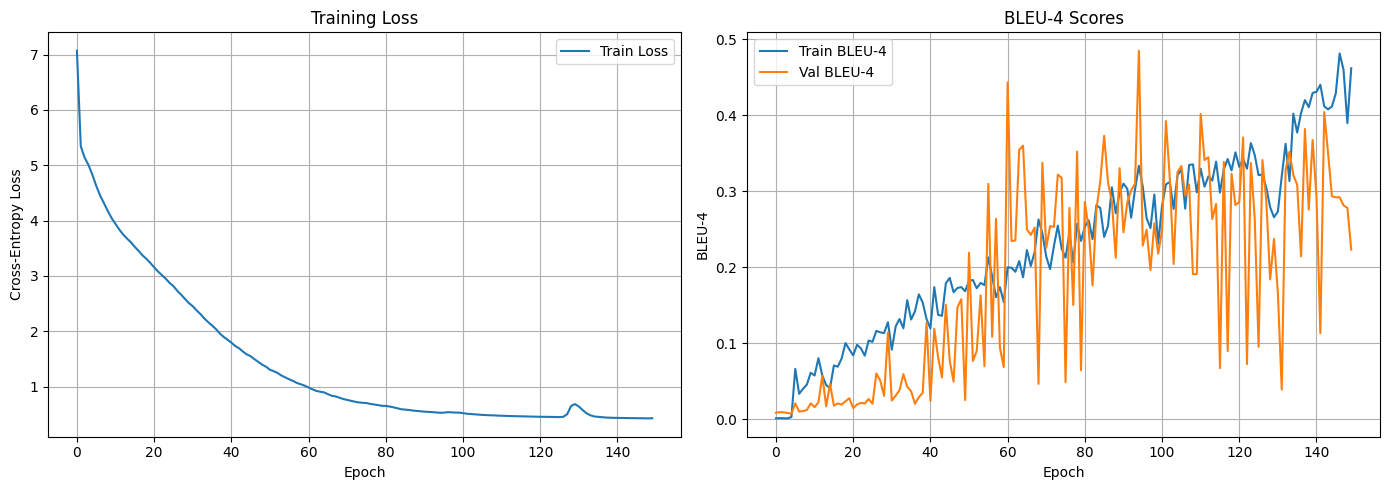

In [22]:
model.plot_history()

In [23]:
model.evaluate_bleu(processor.test_data)

100%|██████████| 100/100 [00:22<00:00,  4.53it/s]

BLEU-1: 0.5921
BLEU-2: 0.4319
BLEU-3: 0.3504
BLEU-4: 0.3042


{'bleu-1': 0.5921152388172858,
 'bleu-2': 0.431883764808351,
 'bleu-3': 0.35035457435540324,
 'bleu-4': 0.30423649396651264}

In [24]:
samples = processor.train_data[:5]  # known to be from training set
for img_name, _ in samples:
    img_path = os.path.join(CONFIG['image_dir'], img_name)
    pred = model.greedy_decode(img_path)
    print("Predicted:", ' '.join(pred))
    print("Ground Truth:", processor.captions_dict[img_name][:1])


Predicted: a young child jumps up a picture full of his camera .
Ground Truth: ['Boy looks backwards to the camera while riding in a swing at an amusement park .']
Predicted: a match for a blond jersey is standing at the stick .
Ground Truth: ['Female athlete for the bulls is holding what looks to be a hockey stick , with rocks and trees in the back .']
Predicted: a boy diving headfirst into a pool .
Ground Truth: ['Four birds are chasing another bird which has a piece of food in its mouth']
Predicted: a small child jumps on a colorful toy in the street .
Ground Truth: ['A little girl is playing with a colorful toy in the ground .']
Predicted: male and woman protesters displaying posters against censorship of photographs and photographers .
Ground Truth: ['Male and woman protesters displaying posters against censorship of photographs and photographers .']


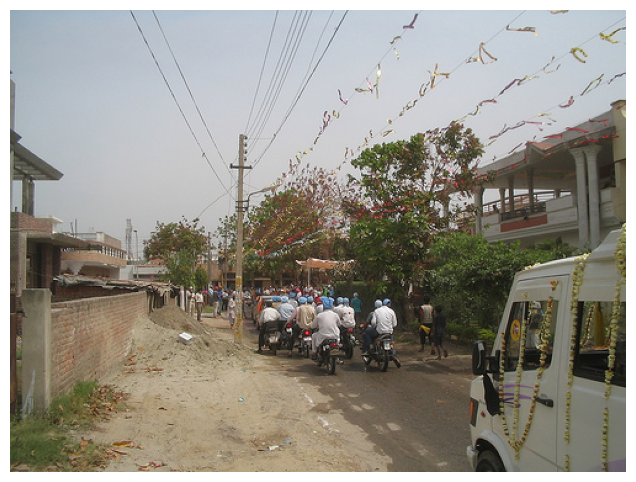

Ground-truth captions:
- A group of turbaned men ride motorbikes away from the viewer down a tree edged street while a white van follows them .
- People riding mopeds on a small road being followed by a white van with streamers on it .
- A road is fairly busy somewhere in the middle east .
- People riding on motorcycles in the street .
- Bikers ride down a busy rural street .

Generated caption:
a group of turbaned men ride motorbikes away from the viewer down a tree edged street while a white van follows them .


Audio saved to caption_audio01.mp3


/tmp/ipykernel_62523/2502600238.py:345: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)


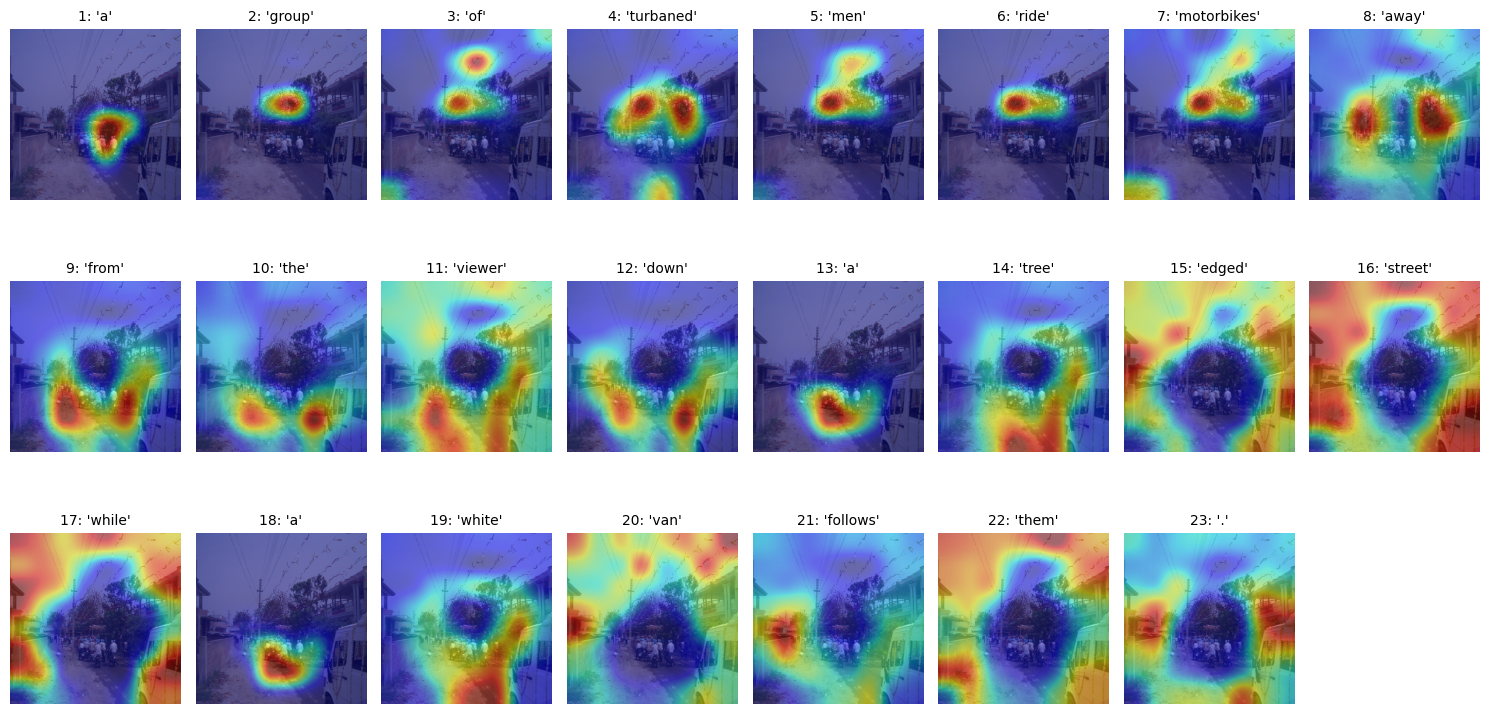

In [25]:
sample_pair = random.choice(processor.train_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

In [34]:
# build UN-shuffled dataset but keep batching
debug_ds = processor.build_dataset(
    processor.train_data,
    shuffle=False, cache=False, training=True)

# get first batch
img_tensor, tok_ids, *_ = next(iter(debug_ds))

first_caption = tok_ids[0].numpy()        # <- pick the first example
decoded = ' '.join(
    processor.tokenizer.index_word.get(int(idx), '')
    for idx in first_caption if idx != 0)

print('Decoded caption:', decoded)
print('Ground-truth   :', processor.train_data[0][1])


Decoded caption: <start> a small child on a rotary swing ride at an amusement park . <end>
Ground-truth   : <start> a small child on a rotary swing ride at an amusement park . <end>
